**Prophet Model to compare weeday and weekend**
**Building a model and train it using monthly data**

19:19:25 - cmdstanpy - INFO - Chain [1] start processing
19:19:26 - cmdstanpy - INFO - Chain [1] done processing


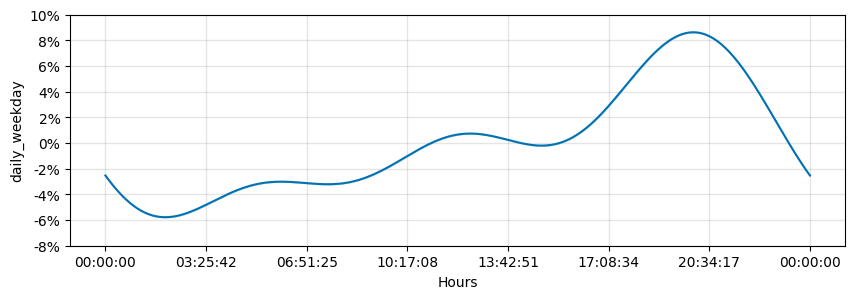

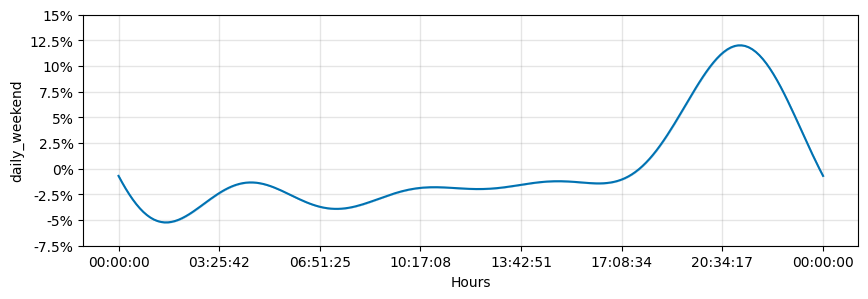

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import pytz
from prophet import Prophet
from prophet.plot import plot_seasonality
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv('June.csv',parse_dates=['time'])

#  Convert to CET and format
cet_timezone = pytz.timezone('CET')
time_series_data_cet = df['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone).dt.strftime('%Y-%m-%d %H:%M:%S')

df = pd.DataFrame({'ds': df['time'],'y': df['people_count']})

#checks if the day of the week for that date is either Friday (4) or Saturday (5). The function returns True if it's a weekend and False otherwise.
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return (date.dayofweek == 4 or date.dayofweek == 5)

df['weekend'] = df['ds'].apply(is_weekend)
df['weekday'] = ~df['ds'].apply(is_weekend)

df.head()

#Disable the default daily seasonailty instead use the conditional seasonailty
#Fourier order used to check the goodness of fit. Value too high, fits the curve considering outliers and leads to overfitting
model = Prophet(seasonality_mode='multiplicative',weekly_seasonality=True,daily_seasonality=False)

model.add_seasonality(name='daily_weekend',period=1, fourier_order=4,condition_name='weekend',prior_scale=0.01)

model.add_seasonality(name='daily_weekday', period=1,fourier_order=4,condition_name='weekday',prior_scale=0.01)

model.fit(df)

future = model.make_future_dataframe(periods=2*24,freq='10T')
future['weekend'] =  future['ds'].apply(is_weekend)
future['weekday'] = ~future['ds'].apply(is_weekend)

forecast = model.predict(future)

fig1 = plot_seasonality(model, 'daily_weekday', figsize=(10, 3))

plt.show()

fig2 = plot_seasonality(model, 'daily_weekend', figsize=(10, 3))

plt.show()

**Monthly Model**

**Training Phase**

00:12:26 - cmdstanpy - INFO - Chain [1] start processing
00:12:29 - cmdstanpy - INFO - Chain [1] done processing


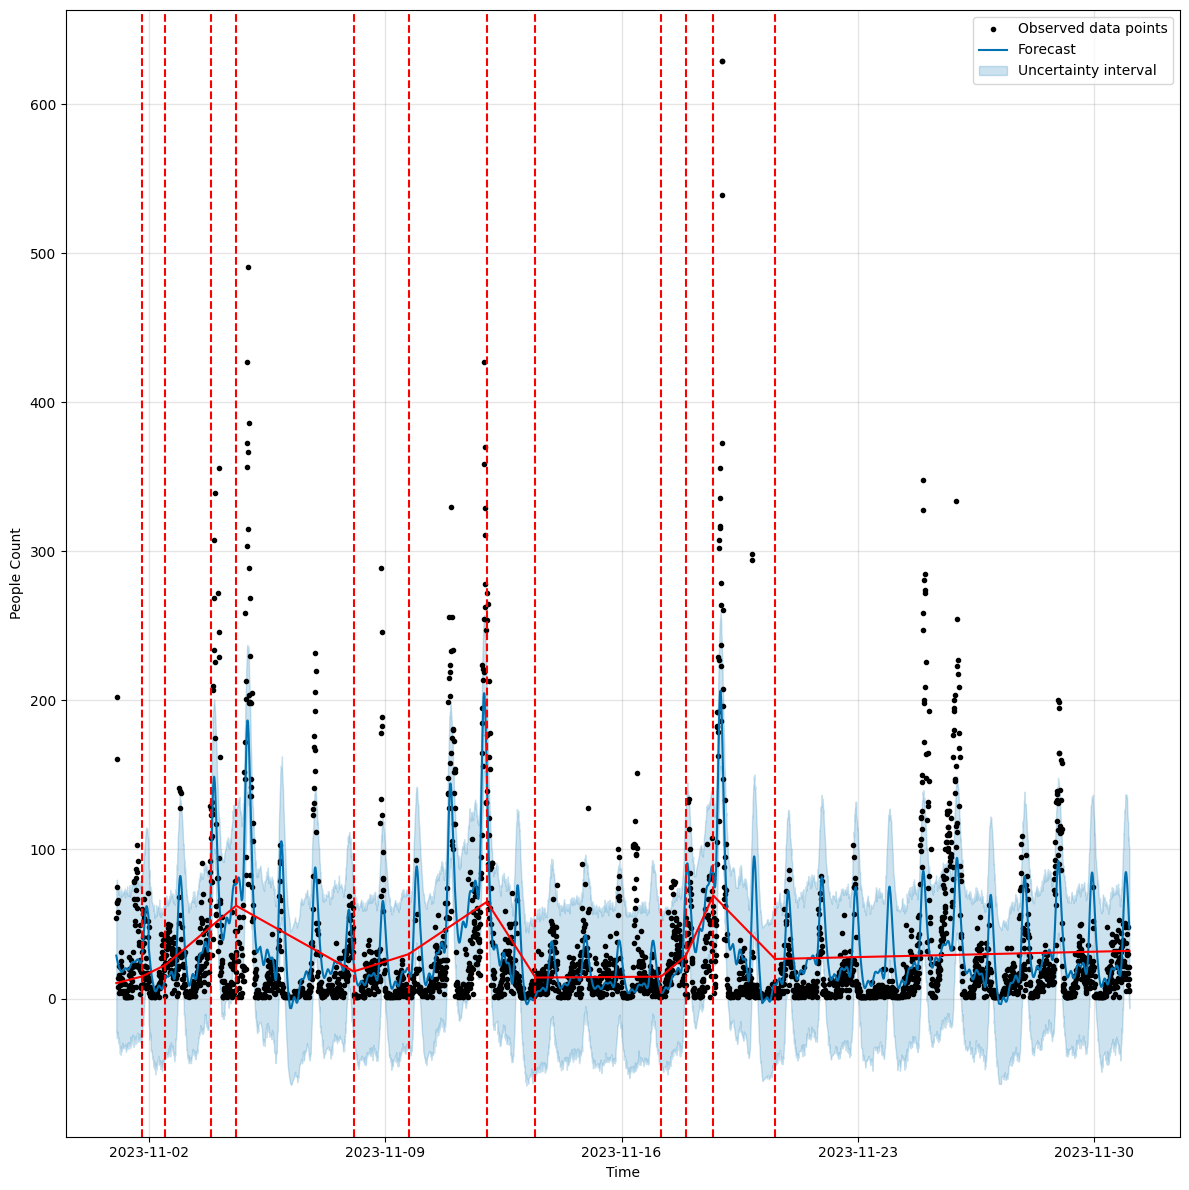

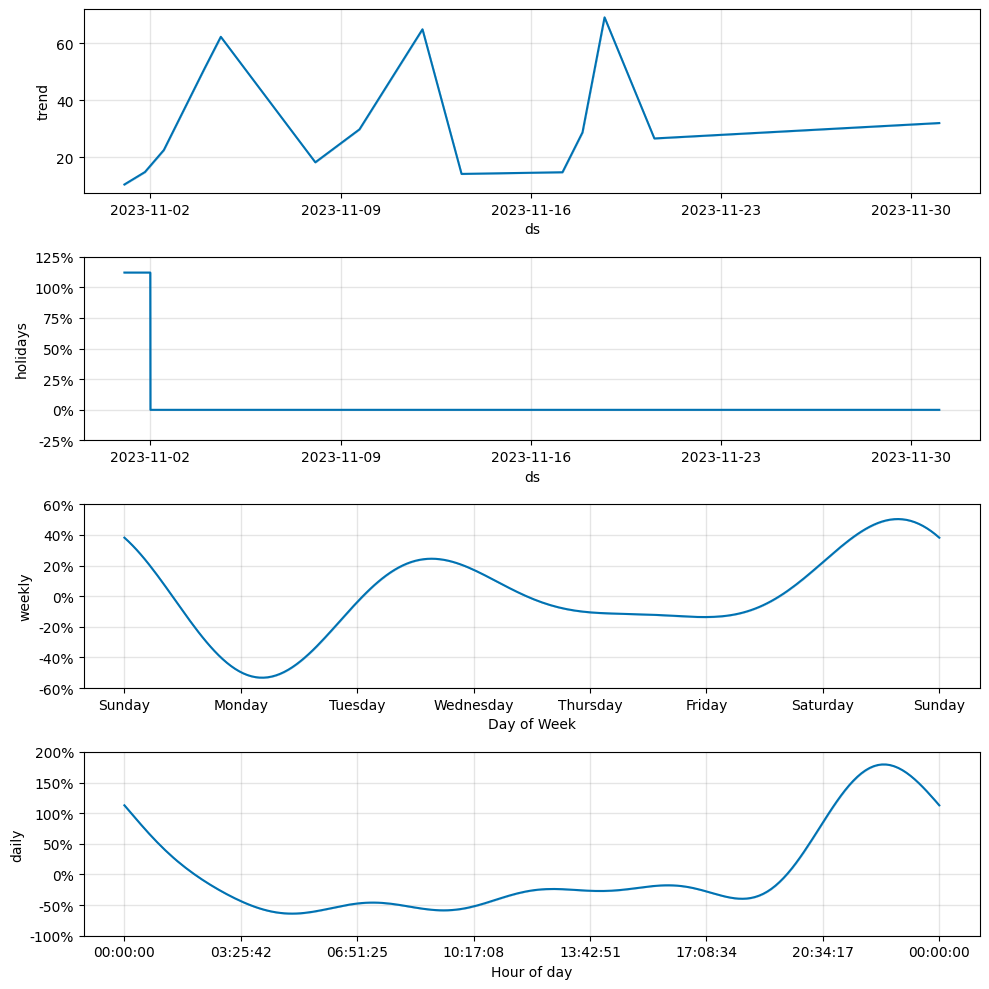

,holiday,effect
0,New Year's Day,0.00000
1,Epiphany,0.00000
2,Good Friday,0.00000
3,Easter Monday,0.00000
4,Labor Day,0.00000
5,Ascension Day,0.00000
6,Whit Monday,0.00000
7,Corpus Christi,0.00000
8,Assumption Day,0.00000
9,Sandkerwa Fest,0.00000


In [197]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.make_holidays import make_holidays_df
from scipy import stats

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv('Nov.csv', parse_dates=['time'])

# Convert to CET and remove timezone information
cet_timezone = pytz.timezone('CET')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone).dt.tz_localize(None)

# Create the training set
monthly_training_set = pd.DataFrame({'ds': df['time'], 'y': df['people_count']})
#-------------------------------------------------------------------------------#

# Make sure year_list is a list of integers
year_list = [2023]

# Create a DataFrame of holidays
holidays_df = make_holidays_df(year_list=year_list, country='DE', province='BY')

#-------------------------------------------------------------------------------#
#Adding Sandkerwa 24.8.23 to 28.8.23
past_sandkerwa_holidays = pd.DataFrame({'holiday':'Sandkerwa Fest',
                                   'ds': pd.to_datetime(['2023-08-24',
                                                         '2023-08-25',
                                                         '2023-08-26',
                                                         '2023-08-27',
                                                         '2023-08-28']),
                                    'lower_window': 0,
                                    'upper_window': 4})

holidays = pd.concat([holidays_df,past_sandkerwa_holidays]).sort_values('ds').reset_index(drop=True)

#-------------------------------------------------------------------------------#

# Initialize and fit the Prophet model
# The order of a polynomial is proportional to the number of bends the curve can take in order to fit the data.
monthly_training_model = Prophet(seasonality_mode='multiplicative',weekly_seasonality=3,daily_seasonality=5,seasonality_prior_scale=0.05,changepoint_prior_scale=0.1,changepoint_range=0.65,holidays=holidays)

monthly_training_model.fit(monthly_training_set)

# Create a future DataFrame for predictions
# future = training_model.make_future_dataframe(periods=2000, freq='10T')

# Make predictions
monthly_forecast = monthly_training_model.predict()

fig = monthly_training_model.plot(monthly_forecast,figsize=(12,12),include_legend=True,xlabel="Time",ylabel="People Count")
# Plot the forecast
# fig_1 = training_model.plot(forecast,figsize=(15,15))
fig_2 = monthly_training_model.plot_components(monthly_forecast,figsize=(10,10))

#Identifying the trend
add_changepoints_to_plot(fig.gca(), monthly_training_model, monthly_forecast)
plt.show()
#-------------------------------------------------------------------------------#
#Adding Holidays to the model to see its effect

def first_non_zero(forecast, holiday):
    non_zero_values = forecast[forecast[holiday] != 0][holiday].values
    return non_zero_values[0] if non_zero_values.size > 0 else 0

pd.DataFrame({'holiday': monthly_training_model.train_holiday_names,
              'effect': [first_non_zero(monthly_forecast, holiday) for holiday in monthly_training_model.train_holiday_names]})


**Monthly Model Testing Phase**

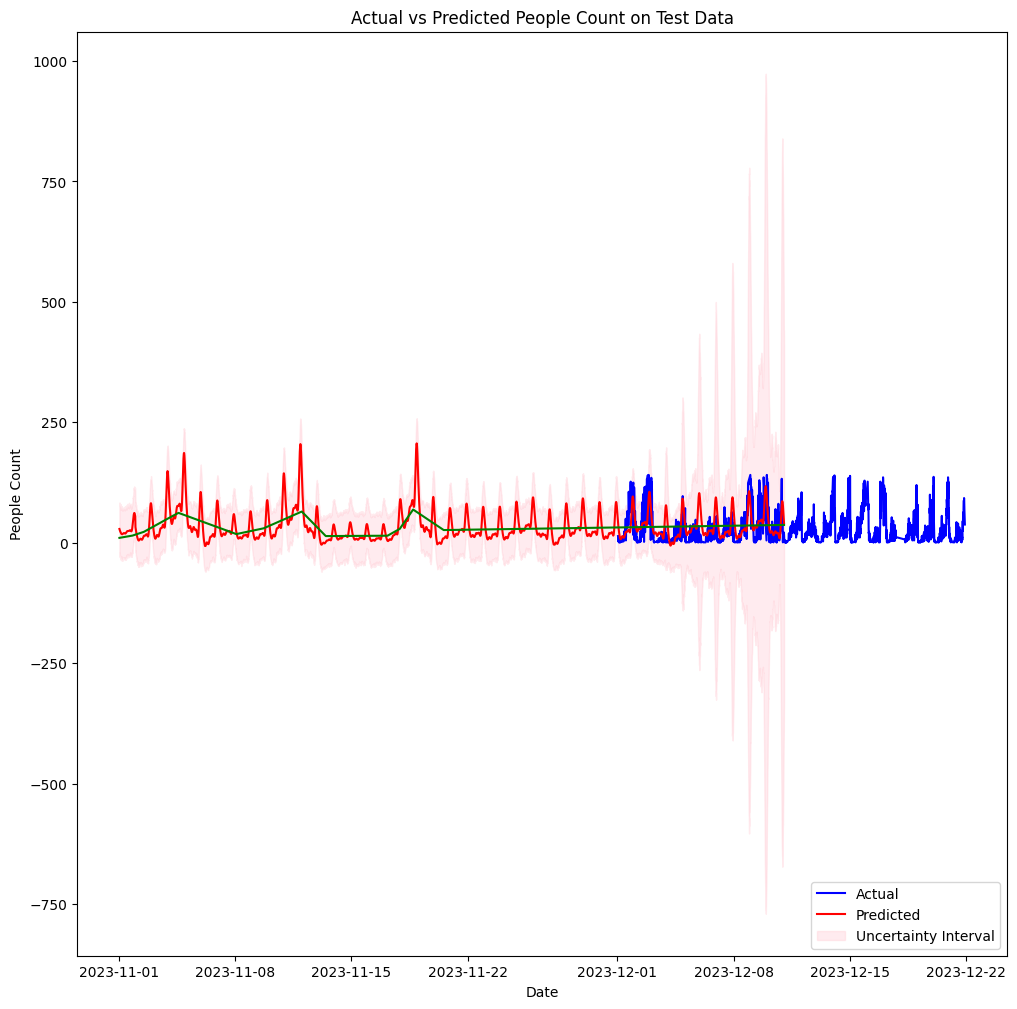

Empty DataFrame
Columns: [ds, Sandkerwa Fest]
Index: []


In [205]:
#Testing the model

# containing datetime values for the test period
df_test = pd.read_csv('Dec.csv', parse_dates=['time'])

# Convert to CET and remove timezone information
cet_timezone = pytz.timezone('CET')
df_test['time'] = df_test['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone).dt.tz_localize(None)


# Create the testing set
monthly_testing_set = pd.DataFrame({'ds': df_test['time'], 'y': df_test['people_count']})


# Create a future DataFrame for the test data
monthly_future_test = monthly_training_model.make_future_dataframe(periods=6*24*10, freq='10min')

# Make predictions on the test data
monthly_forecast_test = monthly_training_model.predict(monthly_future_test)


#Working on dealing with outliers

outliers_df = monthly_testing_set[(stats.zscore(monthly_testing_set['y'])<1.65)]


monthly_testing_set = outliers_df


# Plot the actual vs predicted values for the test period
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(monthly_testing_set['ds'], monthly_testing_set['y'], label='Actual', color='blue')
ax.plot(monthly_forecast_test['ds'], monthly_forecast_test['yhat'], label='Predicted', color='red')
ax.fill_between(monthly_forecast_test['ds'], monthly_forecast_test['yhat_lower'], monthly_forecast_test['yhat_upper'], color='pink', alpha=0.3, label='Uncertainty Interval')
ax.legend(loc='lower right')
plt.xlabel('Date')
plt.ylabel('People Count')
plt.title('Actual vs Predicted People Count on Test Data')
add_changepoints_to_plot(fig.gca(), monthly_training_model, monthly_forecast_test,cp_linestyle='',cp_color='green')
plt.show()
print(monthly_forecast_test[monthly_forecast_test['ds'].isin(['2023-08-24',
                                    '2023-08-25',
                                    '2023-08-26',
                                    '2023-08-27',
                                    '2023-08-28'
                                  ])][['ds','Sandkerwa Fest']])


**Default Prophet Model**

**Contains all default parameters and takes 7 days data to forecast 1 day** 

**Training Phase**

21:33:54 - cmdstanpy - INFO - Chain [1] start processing
21:33:55 - cmdstanpy - INFO - Chain [1] done processing
21:33:55 - cmdstanpy - INFO - Chain [1] start processing
21:33:55 - cmdstanpy - INFO - Chain [1] done processing


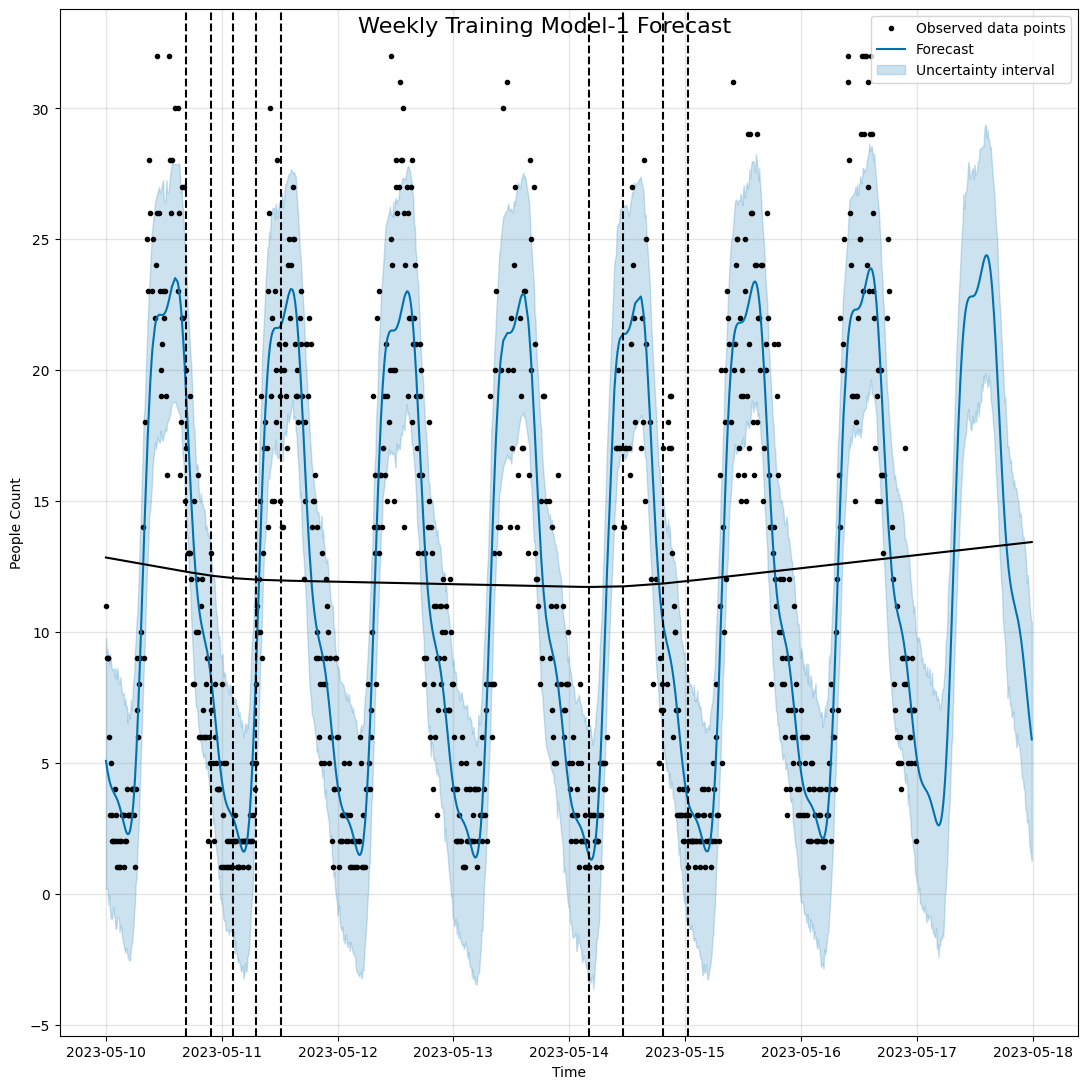

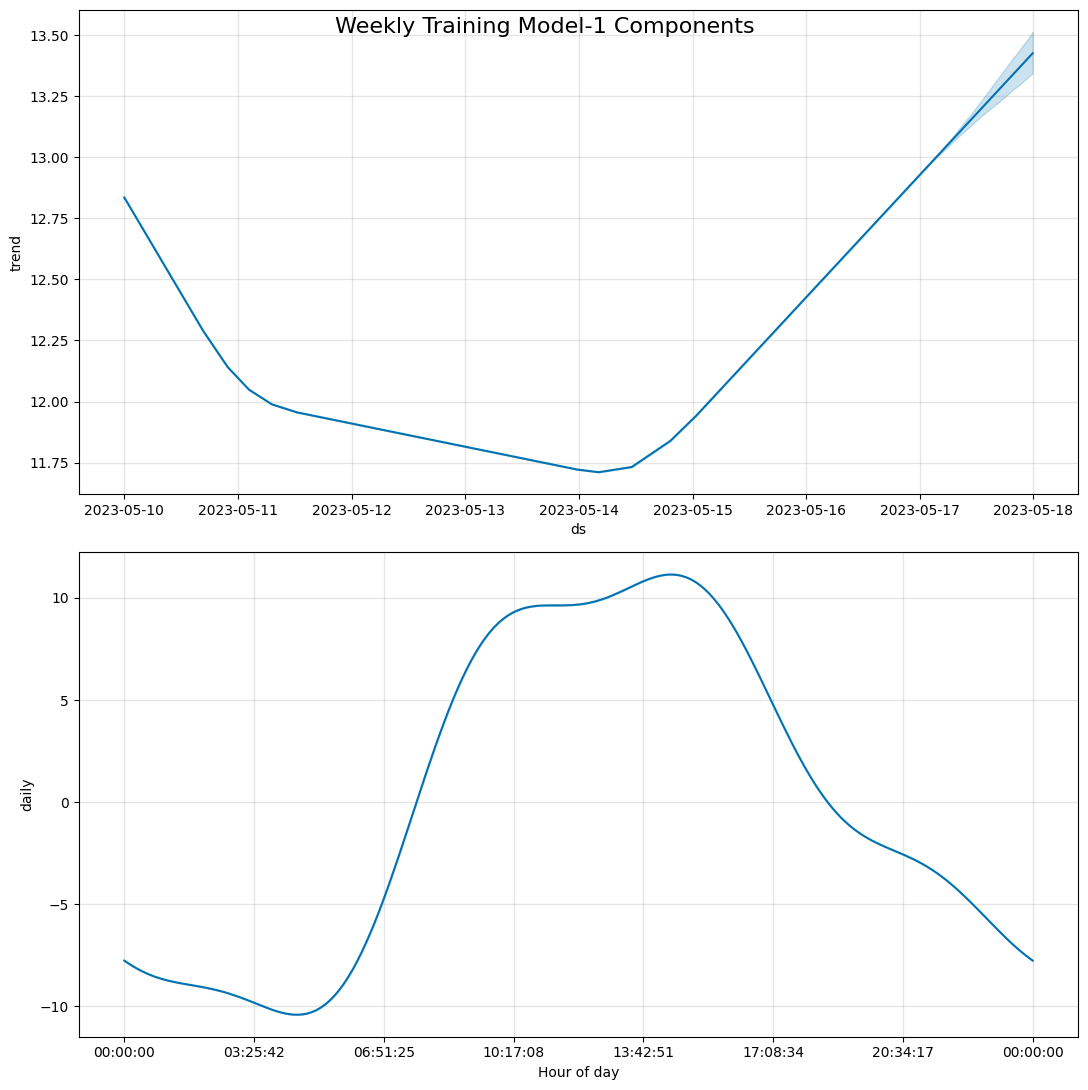

In [20]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv('May.csv', parse_dates=['time'])

# Convert to CET and remove timezone information
cet_timezone = pytz.timezone('CET')
df['time'] = df['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone).dt.tz_localize(None)

# Choose the start date and end date for the one-week subset
start_date = '2023-05-10 00:00:00'
end_date = '2023-05-16 23:59:59'


# Filter the DataFrame to include only the data for the selected week
selected_week_data = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

# # Display the selected week data
# print(selected_week_data)

# Create the training set
training_set = pd.DataFrame({'ds': selected_week_data['time'], 'y': selected_week_data['people_count']}).dropna()


# Initialize and fit the Prophet model for 1 week

dummy_weekly_training_model = Prophet()

dummy_weekly_training_model.fit(training_set)

# Make predictions
dummy_weekly_forecast = dummy_weekly_training_model.predict()

#Filter the outliers
filtered_training_set = training_set[(training_set['y'] > dummy_weekly_forecast['yhat_lower'].values) 
                                     & (training_set['y'] < dummy_weekly_forecast['yhat_upper'].values)]
#ignore the values which are above and below default UI

weekly_training_model = Prophet()

weekly_training_model.fit(filtered_training_set)

# Create a future DataFrame for predictions
future = weekly_training_model.make_future_dataframe(periods=144, freq='10min')


# Make predictions
weekly_forecast = weekly_training_model.predict(future)


# Plot the forecast with a title
fig = weekly_training_model.plot(weekly_forecast, figsize=(11,11), include_legend=True, xlabel="Time", ylabel="People Count")
fig.suptitle("Weekly Training Model-1 Forecast", fontsize=16)

# Plot the components with a title
fig_2 = weekly_training_model.plot_components(weekly_forecast, figsize=(11,11))
fig_2.suptitle("Weekly Training Model-1 Components", fontsize=16)

# Identifying the trend
add_changepoints_to_plot(fig.gca(), weekly_training_model, weekly_forecast, cp_color='black', cp_linestyle='--')

plt.show()







**Default Prophet Model**

**Contains all default parameters and takes 7 days data to forecast 1 day** 

**Testing Phase**

21:41:38 - cmdstanpy - INFO - Chain [1] start processing
21:41:38 - cmdstanpy - INFO - Chain [1] done processing


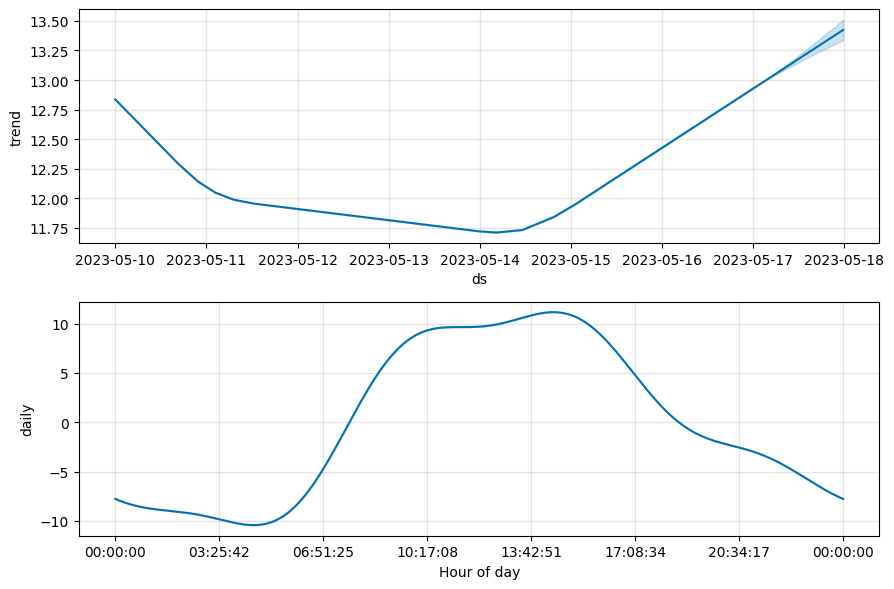

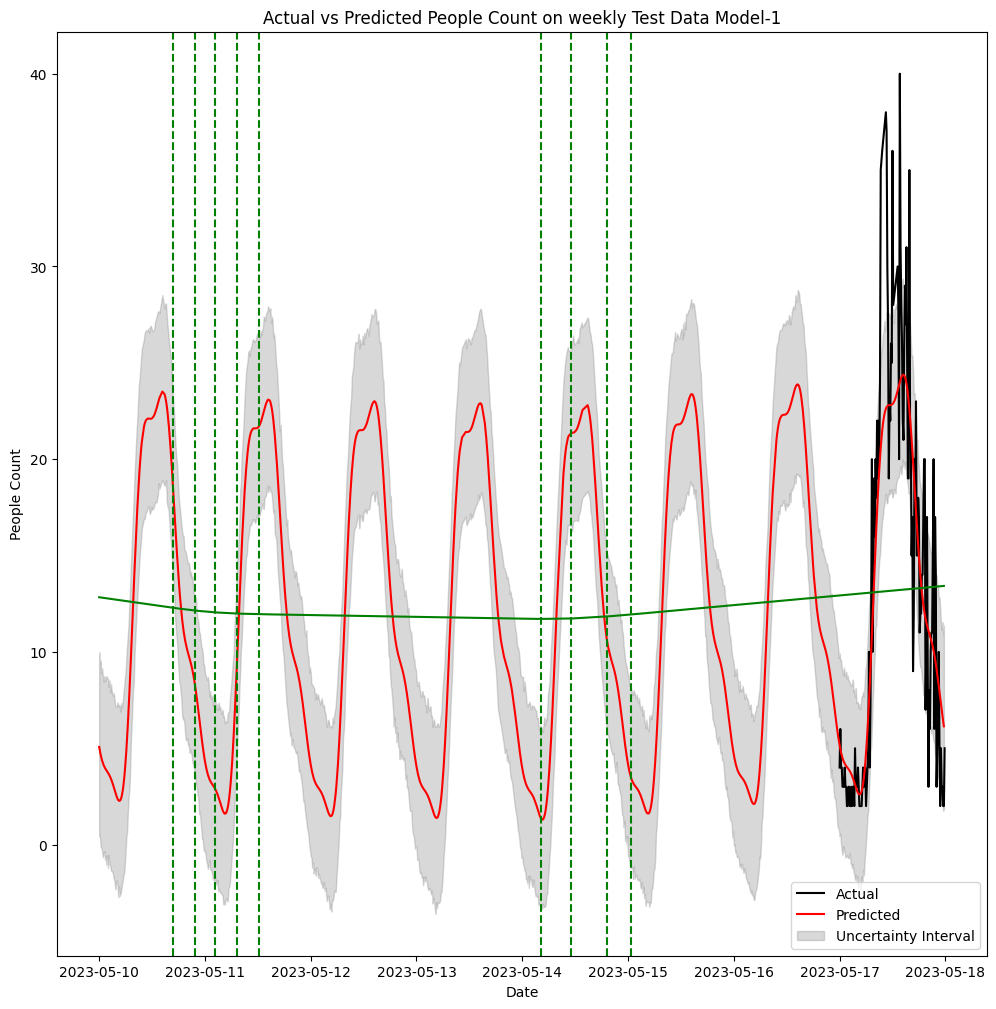

In [28]:
from prophet.plot import plot_components


# containing datetime values for the test period
df_test = pd.read_csv('May.csv', parse_dates=['time'])

# Convert to CET and remove timezone information
cet_timezone = pytz.timezone('CET')
df_test['time'] = df_test['time'].dt.tz_localize('UTC').dt.tz_convert(cet_timezone).dt.tz_localize(None)


# Choose the start date and end date for the one-week subset
test_start_date = '2023-05-17 00:00:00'
test_end_date = '2023-05-17 23:59:59'

# Filter the DataFrame to include only the data for the selected week
selected_week_data = df_test[(df_test['time'] >= test_start_date) & (df_test['time'] <= test_end_date)]

# print(selected_week_data)
# Create the testing set

weekly_testing_set = pd.DataFrame({'ds': selected_week_data['time'], 'y': selected_week_data['people_count']})

#Working on dealing with outliers

dummy_weekly_testing_model = Prophet()


dummy_weekly_testing_model.fit(weekly_testing_set)

# Make predictions
dummy_weekly_forecast = dummy_weekly_testing_model.predict()

#Filter the outliers
filtered_testing_set = weekly_testing_set[(weekly_testing_set['y'] > dummy_weekly_forecast['yhat_lower'].values) & (weekly_testing_set['y'] < dummy_weekly_forecast['yhat_upper'].values)]
#ignore the values which are above and below 80% UI

# Create a future DataFrame for the test data
weekly_future_test = weekly_training_model.make_future_dataframe(periods=len(weekly_testing_set['ds']), freq='10min')

# Make predictions on the test data
weekly_forecast_test = weekly_training_model.predict(weekly_future_test)

fig3 = plot_components(weekly_training_model,weekly_forecast_test)


# Plot the actual vs predicted values for the test period
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(filtered_testing_set['ds'], filtered_testing_set['y'], label='Actual', color='black')  # Change color to black
ax.plot(weekly_forecast_test['ds'], weekly_forecast_test['yhat'], label='Predicted', color='red')  # Change color to gray
ax.fill_between(weekly_forecast_test['ds'], weekly_forecast_test['yhat_lower'], weekly_forecast_test['yhat_upper'], color='grey', alpha=0.3, label='Uncertainty Interval')  # Change color to light gray
ax.legend()
plt.xlabel('Date')
plt.ylabel('People Count')
plt.title('Actual vs Predicted People Count on weekly Test Data Model-1')
add_changepoints_to_plot(fig.gca(), weekly_training_model, weekly_forecast_test, cp_linestyle='--', cp_color='green')  # Change changepoint linestyle to dashed
plt.show()


import plotly.graph_objects as go

# Create traces
actual_trace = go.Scatter(x=filtered_testing_set['ds'], y=filtered_testing_set['y'], mode='lines', name='Actual Count', line=dict(color='black'))
predicted_trace = go.Scatter(x=weekly_forecast_test['ds'], y=weekly_forecast_test['yhat'], mode='lines', name='Predicted Count', line=dict(color='red', width=4))
uncertainty_trace = go.Scatter(x=weekly_forecast_test['ds'], y=weekly_forecast_test['yhat_upper'], fill=None, mode='lines', line=dict(color='grey'), showlegend=False)
uncertainty_trace_filled = go.Scatter(x=weekly_forecast_test['ds'], y=weekly_forecast_test['yhat_lower'], fill='tonexty', mode='lines', line=dict(color='grey'), name='Uncertainty Interval')

# Define layout
layout = go.Layout(
    title=dict(text='Actual vs Predicted People Count Model-1 (with custom parameters and without regressor)', font=dict(color='black'), x=0.5),
    xaxis=dict(
        title='Date',
        title_font=dict(color='black'),
        tickfont=dict(color='black')  # Set x-axis tick labels to black
    ),
    yaxis=dict(
        title='People Count',
        title_font=dict(color='black'),
        tickfont=dict(color='black')  # Set y-axis tick labels to black
    ),
    legend=dict(x=0.01, y=0.99, font=dict(color='black')),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

# Define lower and upper bounds for the x-axis
lower_bound = filtered_testing_set['ds'].min()
upper_bound = filtered_testing_set['ds'].max()

# Create figure and add traces
fig = go.Figure(data=[actual_trace, predicted_trace, uncertainty_trace, uncertainty_trace_filled], layout=layout)
fig.update_xaxes(range=[lower_bound, upper_bound], tickmode='auto', dtick='H1')

# Save the figure as an HTML file
fig.write_html('actual_vs_predicted_bw_model1.html', auto_open=True)

  0%|          | 0/2 [00:00<?, ?it/s]

21:36:18 - cmdstanpy - INFO - Chain [1] start processing
21:36:18 - cmdstanpy - INFO - Chain [1] done processing
21:36:18 - cmdstanpy - INFO - Chain [1] start processing
21:36:18 - cmdstanpy - INFO - Chain [1] done processing


  horizon        mse      rmse       mae      mape     mdape     smape  \
0  1 days  16.183634  4.022889  2.902172  0.306057  0.238524  0.317022   

   coverage  
0  0.808429  


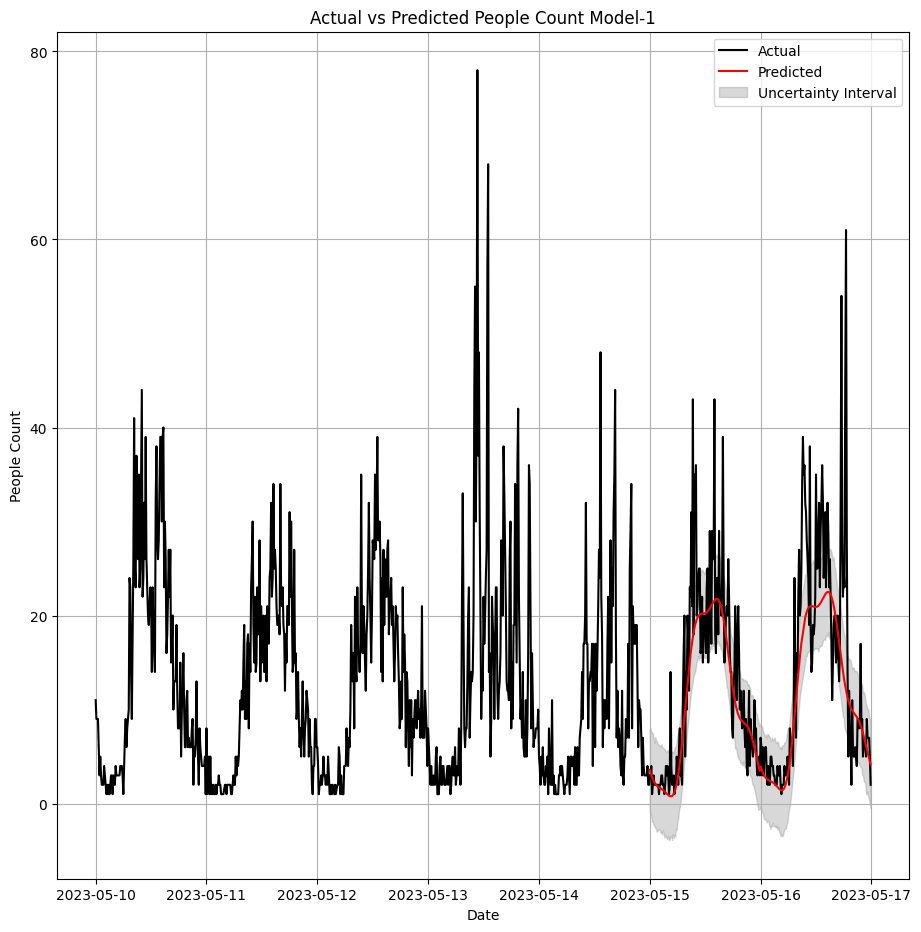

In [25]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


default_model_cv = cross_validation(weekly_training_model, horizon= '1 days', period='1 days', initial='4 days')

# # Evaluate model performance
df_p = performance_metrics(default_model_cv,rolling_window=1)
print(df_p)

# Extract relevant columns from df
actual_data = training_set[['ds', 'y']]

# Extract relevant columns from df_cv
predicted_data = default_model_cv[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Plot actual vs predicted values
plt.figure(figsize=(11, 11))
plt.plot(actual_data['ds'], actual_data['y'], label='Actual', color='black')  # Set actual data line color to black
plt.plot(predicted_data['ds'], predicted_data['yhat'], label='Predicted', color='red')  # Set predicted data line color to red
plt.fill_between(predicted_data['ds'], predicted_data['yhat_lower'], predicted_data['yhat_upper'], color='grey', alpha=0.3, label='Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('People Count')
plt.title('Actual vs Predicted People Count Model-1')
plt.grid(visible='True')
plt.legend()
plt.show()



In [52]:
import itertools
import numpy as np
#-----------------------------------------------------------#
# Working on grid search to find best combinations of parameters to build a model

param_grid = {'changepoint_prior_scale': [0.5, 0.1, 0.01],

              'seasonality_prior_scale': [10.0, 1.0, 0.1],

              'seasonality_mode': ['additive', 'multiplicative']}

all_params = [dict(zip(param_grid.keys(), value))

              for value in itertools.product(

                                  *param_grid.values())]

rmse_values= []

for params in all_params:

    model = Prophet(daily_seasonality=4, **params).fit(filtered_training_set)

    df_cv = cross_validation(model,

                             horizon='1 days',

                             parallel='processes')

    df_p = performance_metrics(df_cv, rolling_window=1)

    rmse_values.append(df_p['rmse'].values[0])

    results = pd.DataFrame(all_params)

results['rmse'] = rmse_values

results.head()

best_params = all_params[np.argmin(rmse_values)]

print(best_params)

11:40:13 - cmdstanpy - INFO - Chain [1] start processing
11:40:14 - cmdstanpy - INFO - Chain [1] done processing
11:40:21 - cmdstanpy - INFO - Chain [1] start processing
11:40:21 - cmdstanpy - INFO - Chain [1] done processing
11:40:27 - cmdstanpy - INFO - Chain [1] start processing
11:40:27 - cmdstanpy - INFO - Chain [1] done processing
11:40:33 - cmdstanpy - INFO - Chain [1] start processing
11:40:33 - cmdstanpy - INFO - Chain [1] done processing
11:40:38 - cmdstanpy - INFO - Chain [1] start processing
11:40:38 - cmdstanpy - INFO - Chain [1] done processing
11:40:43 - cmdstanpy - INFO - Chain [1] start processing
11:40:44 - cmdstanpy - INFO - Chain [1] done processing
11:40:49 - cmdstanpy - INFO - Chain [1] start processing
11:40:49 - cmdstanpy - INFO - Chain [1] done processing
11:40:55 - cmdstanpy - INFO - Chain [1] start processing
11:40:55 - cmdstanpy - INFO - Chain [1] done processing
11:41:00 - cmdstanpy - INFO - Chain [1] start processing
11:41:00 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}
